In [9]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


# Define Jaeger API URL (jager pod endpoint of 'social-network2' namespace)
JAEGER_API_URL = "http://192.168.69.212:16686/api/traces" # in 'social-network2' namespace

# Define parameters for the query
service_name = "compose-post-service" #'home-timeline-service' #"compose-post-service"
lookback = "60m"
limit = 1000

# Function to query Jaeger API
def query_jaeger(service_name, lookback, limit):
    params = {
        "service": service_name,
        "lookback": lookback,
        "limit": limit
    }
    response = requests.get(JAEGER_API_URL, params=params)
    response.raise_for_status()
    return response.json()


# Parse the trace data
def parse_jaeger_data(data):
    traces = data['data']
    trace_list = []
    for trace in traces:
        trace_id = trace['traceID']
        for span in trace['spans']:
            operation = span['operationName']
            start_time = datetime.utcfromtimestamp(span['startTime'] / 1e6)
            duration = span['duration'] / 1e3  # Convert microseconds to milliseconds
            trace_list.append({
                "trace_id": trace_id,
                "operation": operation,
                "start_time": start_time,
                "duration": duration
            })
    return pd.DataFrame(trace_list)


# Fetch trace data from Jaeger
data = query_jaeger(service_name, lookback, limit)

# Parse the data into a DataFrame
df = parse_jaeger_data(data)

# Convert 'start_time' to datetime and 'duration' to numeric
df['start_time'] = pd.to_datetime(df['start_time'])


In [10]:

df.to_csv('NetMARKS_composePost.csv')

In [11]:
df

,trace_id,operation,start_time,duration
0,0955c2fc7b550012,compose_user_mentions_memcached_get_client,2024-07-15 07:29:11.282208,73.176
1,0955c2fc7b550012,compose_user_mentions_mongo_find_client,2024-07-15 07:29:11.355426,35.062
2,0955c2fc7b550012,compose_user_mentions_server,2024-07-15 07:29:11.282200,108.309
3,0955c2fc7b550012,url_mongo_insert_client,2024-07-15 07:29:11.246180,25.358
4,0955c2fc7b550012,compose_urls_server,2024-07-15 07:29:11.246057,25.936
...,...,...,...,...
3753,0a4e69748bebcece,compose_urls_server,2024-07-15 07:29:37.801640,19.080
3754,0a4e69748bebcece,write_user_timeline_mongo_insert_client,2024-07-15 07:29:38.094035,17.065
3755,0a4e69748bebcece,write_user_timeline_redis_update_client,2024-07-15 07:29:38.111127,35.045
3756,0a4e69748bebcece,write_user_timeline_server,2024-07-15 07:29:38.093952,52.234


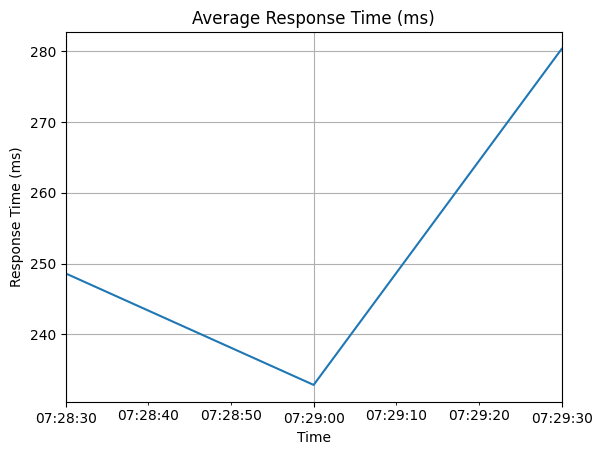

In [12]:
# Display the data
if df.empty:
    print("No trace data found.")
else:
    # print(df)

    # Calculate and plot average response time
    avg_response_time = df.groupby(pd.Grouper(key='start_time', freq='30s'))['duration'].mean() 
    avg_response_time.plot(y='duration', kind='line', title='Average Response Time (ms)')
    plt.xlabel('Time')
    plt.ylabel('Response Time (ms)')
    plt.grid(True)
    plt.show()

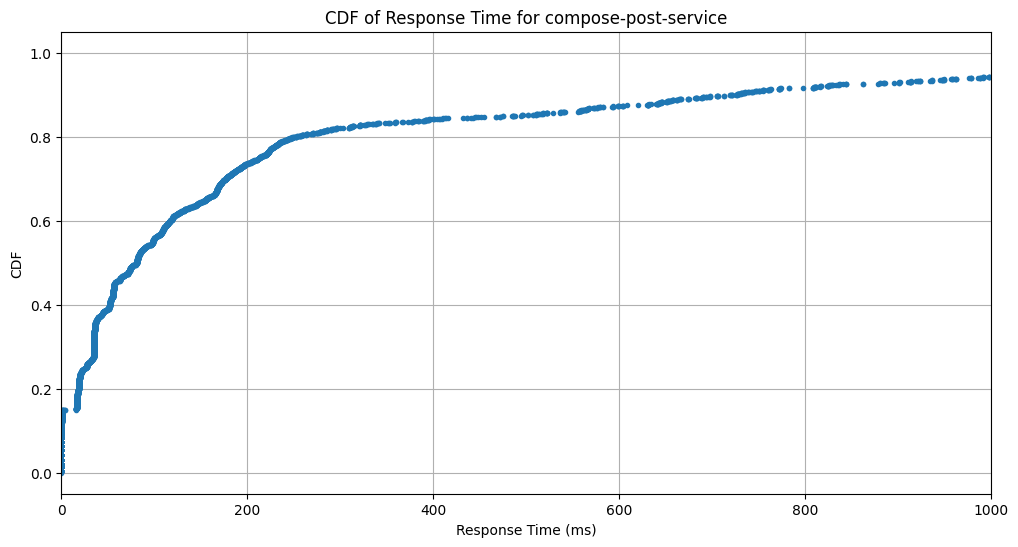

In [13]:

# Check if data is available
if df.empty:
    print("No trace data found.")
else:
    # Convert start_time to datetime for time-based grouping
    
    # Ensure 'duration' column is numeric
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    
    # Drop rows with NaN values in 'duration'
    df = df.dropna(subset=['duration'])

    # Sort the duration values
    sorted_duration = df['duration'].sort_values()

    # Calculate CDF values
    cdf = sorted_duration.rank(method='average', pct=True)

    # Plot the CDF
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_duration, cdf, marker='.', linestyle='none')
    plt.title('CDF of Response Time for compose-post-service')
    plt.xlim(0,1000)
    plt.xlabel('Response Time (ms)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()
